# Visualize lens mocks with substructures

In [1]:
__author__ = 'aymgal'

import os
import copy
import numpy as np
import astropy.io.fits as pf
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.colors import LogNorm
import time

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Plots import lens_plot 
from lenstronomy.Util import util

import fixed_param
import substruct_util
import source_util_HST as source_util

np.random.seed(18)

%matplotlib inline

In [2]:
substruct_mass_range = np.logspace(7, 11, 5)  # in solar masses

In [3]:
# choice of colormaps for image plots
cmap_default = plt.get_cmap('viridis')
cmap_residuals = plt.get_cmap('RdBu_r')
cmap_flux = plt.get_cmap('cubehelix')
cmap_flux.set_bad(color='black', alpha=1)
cmap_flux_with_neg = copy.deepcopy(plt.get_cmap('cubehelix'))
cmap_flux_with_neg.set_bad(color='gray', alpha=1)  # emphasize -negative pixels when in log scale

## Define image size and resolution

In [4]:
# data specifics
num_pix = 110  # number of side pixels
delta_pix = 0.08  # final pixel size in arcsec

# coordinates grid
ra_grid, dec_grid, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(num_pix, delta_pix, subgrid_res=1, inverse=False)


## Lens model, substructures, source position and magnitude

Those parameters are common to HST mock data as well. They are defined on the `fixed_param` module.

In [5]:
# model without substructure ('macro' model)
lens_model_list_macro = fixed_param.lens_model_list  # list of profile names
kwargs_lens_macro = fixed_param.kwargs_lens  # parameter values
lens_model_class_macro = LensModel(lens_model_list=lens_model_list_macro)
print(kwargs_lens_macro)
theta_E_macro = kwargs_lens_macro[0]['theta_E']

LA_macro = LensProfileAnalysis(lens_model_class_macro)
print("macro theta_E = {:.2f}".format(LA_macro.effective_einstein_radius(kwargs_lens_macro, grid_num=400, grid_spacing=0.02)))
print("macro mass M(r) = {:.2e} M_sol for r=2*theta_E".format(substruct_util.mass_in_radius(2 * theta_E_macro)))
print("macro DM mass M_200 = {:.2e} M_sol".format(substruct_util.mass_in_DM_halo(theta_E_macro)))

[{'theta_E': 1.8, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}, {'gamma_ext': 0.05, 'psi_ext': 0, 'ra_0': 0, 'dec_0': 0}]
macro theta_E = 1.79
macro mass M(r) = 3.53e+12 M_sol for r=2*theta_E
macro DM mass M_200 = 7.98e+13 M_sol


In [6]:
# true model with substructure
ra_substruct, dec_substruct = theta_E_macro, 0

profile_substruct = fixed_param.profile_substruct
lens_model_list = lens_model_list_macro + [profile_substruct]
lens_model_class = LensModel(lens_model_list=lens_model_list)
LA = LensProfileAnalysis(lens_model_class)

# build the list of parameter values for each substructure mass
kwargs_lens_range = []
for mass in substruct_mass_range:
    kwargs_lens_updated, c = substruct_util.update_kwargs_with_substruct(kwargs_lens_macro, mass, ra_substruct, dec_substruct, 
                                                                         profile=profile_substruct, concentration_relation='Correr',
                                                                         fixed_concentration=None)
    #print(kwargs_lens_updated[-1])
    theta_E_eff = LA.effective_einstein_radius(kwargs_lens_updated, grid_num=400, grid_spacing=0.02)
    print("macro + SS mass {:.2e} gives theta_E = {:.5f} and concentration {:.5f}".format(mass, theta_E_eff, c))
    kwargs_lens_range.append(kwargs_lens_updated)

macro + SS mass 1.00e+07 gives theta_E = 1.78723 and concentration 18.83605
macro + SS mass 1.00e+08 gives theta_E = 1.78723 and concentration 17.09025
macro + SS mass 1.00e+09 gives theta_E = 1.78723 and concentration 15.20405
macro + SS mass 1.00e+10 gives theta_E = 1.79224 and concentration 13.16494
macro + SS mass 1.00e+11 gives theta_E = 1.82728 and concentration 11.04299


In [7]:
# source position
ra_source, dec_source = fixed_param.ra_source, fixed_param.dec_source

## Substructure halo concentration _vs_ mass substructure

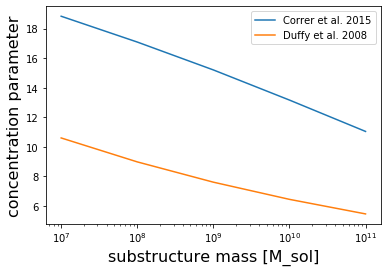

In [8]:
# relation from C. A. Correa, J. S. B. Wyithe, J. Schaye, and A. R. Duffy
plt.xlabel("substructure mass [M_sol]", fontsize=16)
plt.ylabel("concentration parameter", fontsize=16)
plt.semilogx(substruct_mass_range, substruct_util.get_substruct_concentraion_Correr(substruct_mass_range), label="Correr et al. 2015")
plt.semilogx(substruct_mass_range, substruct_util.get_substruct_concentraion_Duffy(substruct_mass_range), label="Duffy et al. 2008")
plt.legend()
plt.show()

## Visualize lens model

### Macro-model only

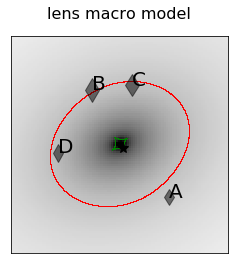

In [9]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
ax.set_title("lens macro model", fontsize=16)
lens_plot.lens_model_plot(ax, lens_model_class_macro, kwargs_lens_macro, 
                          numPix=100, deltaPix=0.06,   # play with these to zoom in/ou in the figure, or increase resolution
                          sourcePos_x=ra_source, sourcePos_y=dec_source,
                          point_source=True, with_caustics=True, coord_inverse=False)
plt.show()

### With substructures added

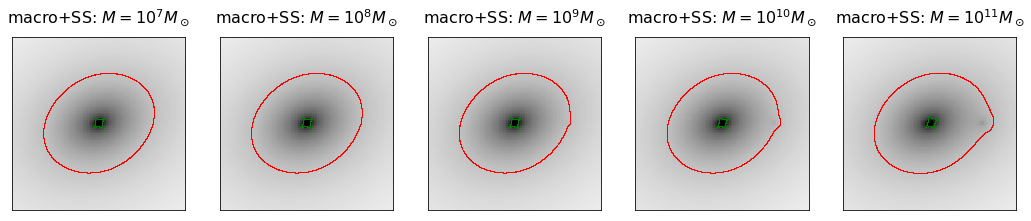

In [10]:
fig = plt.figure(figsize=(18, 3.5))
for i in range(len(substruct_mass_range)):
    ax = plt.subplot(1, len(substruct_mass_range), i+1)
    pow_str = "{:.0f}".format(np.log10(substruct_mass_range[i]))
    title = "macro+SS: " + r"$M=10^{"+pow_str+"}M_\odot$"
    ax.set_title(title, fontsize=16)
    lens_plot.lens_model_plot(ax, lens_model_class, kwargs_lens_range[i], 
                              numPix=100, deltaPix=0.06,   # play with these to zoom in/ou in the figure, or increase resolution
                              sourcePos_x=ra_source, sourcePos_y=dec_source,
                              point_source=False, with_caustics=True, coord_inverse=False)
plt.show()

## Compute negative mass sheet to keep same $\theta_{\rm E}$

0.3676769132219254


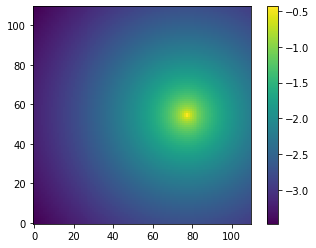

In [11]:
kappa_macro = lens_model_class_macro.kappa(ra_grid, dec_grid, kwargs_lens_macro)
kappa_macro = util.array2image(kappa_macro)

kappa = lens_model_class.kappa(ra_grid, dec_grid, kwargs_lens_range[-1])
kappa = util.array2image(kappa)

kappa_diff = kappa - kappa_macro
kappa_diff_tot = kappa_diff.max()  # mass-sheet to remove
print(kappa_diff_tot)

plt.imshow(np.log10(kappa_diff), origin='lower')
plt.colorbar()
plt.show()

## Substract mass-sheet to model with substructure

/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


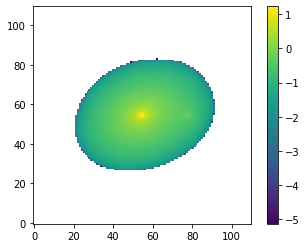

In [12]:
kwargs_ms = [{'kappa_ext': - kappa_diff_tot, 'ra_0':0, 'dec_0': 0}]
lens_model_list_ms = lens_model_list_macro + [profile_substruct] + ['CONVERGENCE']
lens_model_class_ms = LensModel(lens_model_list=lens_model_list_ms)
LA_ms = LensProfileAnalysis(lens_model_class_ms)

kappa_ms = lens_model_class_ms.kappa(ra_grid, dec_grid, kwargs_lens_range[-1] + kwargs_ms)
kappa_ms = util.array2image(kappa_ms)

plt.imshow(np.log10(kappa_ms), origin='lower')
plt.colorbar()
plt.show()

In [13]:
kwargs_lens_range_ms = []
for mass, kwargs_lens in zip(substruct_mass_range, kwargs_lens_range):
    kwargs_lens_ms_updated = kwargs_lens + kwargs_ms
    print(kwargs_lens_ms_updated)
    kwargs_lens_range_ms.append(kwargs_lens_ms_updated)
    print("SS mass {:.2e} minus mass-sheet gives theta_E = {:.5f}".format(mass, LA_ms.effective_einstein_radius(kwargs_lens_ms_updated, grid_num=400, grid_spacing=0.02)))
    

[{'theta_E': 1.8, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}, {'gamma_ext': 0.05, 'psi_ext': 0, 'ra_0': 0, 'dec_0': 0}, {'alpha_Rs': 0.00021444101126084472, 'Rs': 0.025767821525061105, 'r_trunc': 0.12883910762530554, 'center_x': 1.8, 'center_y': 0}, {'kappa_ext': -0.3676769132219254, 'ra_0': 0, 'dec_0': 0}]
SS mass 1.00e+07 minus mass-sheet gives theta_E = 1.30663
[{'theta_E': 1.8, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}, {'gamma_ext': 0.05, 'psi_ext': 0, 'ra_0': 0, 'dec_0': 0}, {'alpha_Rs': 0.0009434941191063073, 'Rs': 0.06118608466552525, 'r_trunc': 0.3059304233276262, 'center_x': 1.8, 'center_y': 0}, {'kappa_ext': -0.3676769132219254, 'ra_0': 0, 'dec_0': 0}]
SS mass 1.00e+08 minus mass-sheet gives theta_E = 1.30663
[{'theta_E': 1.8, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}, {'gamma_ext': 0.05, 'psi_ext': 0, 'ra_0': 0, 'dec_0': 0}, {'alpha_Rs': 0.004114676787182419, 'Rs': 0.14817498480517116, 'r_trunc': 0.7408749240258559, 'center_x': 1.8, 'center_y': 

/Users/aymericg/Documents/EPFL/PhD_LASTRO/Code/Forked/lenstronomy_forked/lenstronomy/Plots/lens_plot.py:40: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(kappa_result), origin='lower', extent=[0, _frame_size, 0, _frame_size], cmap='Greys',


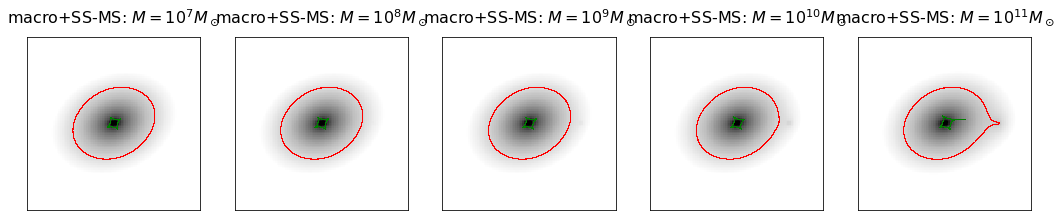

In [14]:
fig = plt.figure(figsize=(18, 3.5))
for i in range(len(substruct_mass_range)):
    ax = plt.subplot(1, len(substruct_mass_range), i+1)
    pow_str = "{:.0f}".format(np.log10(substruct_mass_range[i]))
    title = "macro+SS-MS: " + r"$M=10^{"+pow_str+"}M_\odot$"
    ax.set_title(title, fontsize=16)
    lens_plot.lens_model_plot(ax, lens_model_class_ms, kwargs_lens_range_ms[i], 
                              numPix=100, deltaPix=0.06,   # play with these to zoom in/ou in the figure, or increase resolution
                              sourcePos_x=ra_source, sourcePos_y=dec_source,
                              point_source=False, with_caustics=True, coord_inverse=False)
plt.show()